In [1]:
import pickle
import numpy as np

In [2]:
data_path = '/home/maybe/MOT17/train/MOT17-02-DPM/'

In [3]:
from os import path
from glob import glob
from collections import defaultdict

In [4]:
seqs = defaultdict(dict)
objs = defaultdict(dict)
with open(path.join(data_path, 'gt', 'gt.txt')) as f:
    for seq, obj, *data in [line.strip().split(',') for line in f.readlines()]:
        if int(obj) < 16:
            seqs[int(seq)][int(obj)] = data
            objs[int(obj)][int(seq)] = data

In [5]:
pb = defaultdict(dict)
for file in glob('../results_*.p'):
    obj_id = int(file.split('_')[1].split('.')[0])
    with open(file, 'rb') as f:
        r = pickle.load(f)
    pb[obj_id] = r

In [6]:
rb = defaultdict(dict)
for obj, values in objs.items():
    for v, d in values.items():
        if v < len(pb[obj]):
            rb[v][obj] = pb[obj][v]

## Metrics

In [7]:
def location(rect1, rect2):
    cx1, cy1 = rect1[0] + rect1[2]/2, rect1[1] + rect1[3]/2
    cx2, cy2 = rect2[0] + rect2[2]/2, rect2[1] + rect2[3]/2
    return ((cy2-cy1)**2 + (cx2-cx1)**2)**.5

In [8]:
def overlap(rect1, rect2):
    left = np.maximum(np.maximum(0, rect1[0]), np.maximum(0, rect2[0]))
    right = np.minimum(rect1[0] + rect1[2], rect2[0] + rect2[2])
    top = np.maximum(np.maximum(0, rect1[1]), np.maximum(0, rect2[1]))
    bottom = np.minimum(rect1[1] + rect1[3], rect2[1] + rect2[3])
    intersect = np.maximum(0, right - left) * np.maximum(0, bottom - top)
    intersect = 0 if intersect < 0 else intersect
    union = rect1[2] * rect1[3] + rect2[2] * rect2[3] - intersect
    iou = np.clip(intersect / union, 0, 1)
    return iou

In [9]:
import matplotlib.pyplot as plt

In [10]:
for seq, oo in rb.items():
    if not seq: continue

In [11]:
iou = np.asarray([overlap(np.array(list(map(float, gbox[:4]))), bbox[:4]) for seq, oo in rb.items() for gbox, bbox in zip(seqs[seq].values(), oo.values())])

In [12]:
x_iou = np.arange(0, 1.01, .01)

In [13]:
perf_iou = [iou[np.where(iou>=flag)].size / iou.size for flag in x_iou]

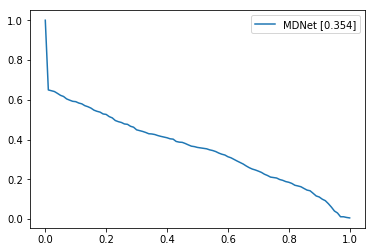

In [14]:
plt.plot(x_iou, perf_iou, label='MDNet [%.3f]' % (sum(perf_iou) / len(perf_iou)))
plt.legend()
plt.show()

In [15]:
cle = np.asarray([location(list(map(float, gbox[:4])), bbox[:4]) for seq, oo in rb.items() for gbox, bbox in zip(seqs[seq].values(), oo.values())])

In [16]:
x_cle = np.arange(0, 50, .1)

In [17]:
perf_cle = [cle[np.where(cle<=flag)].size / cle.size for flag in x_cle]

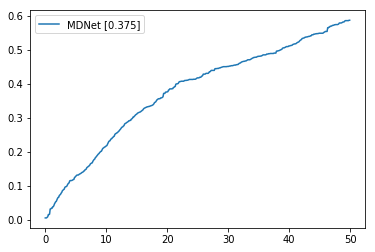

In [18]:
plt.plot(x_cle, perf_cle, label='MDNet [%.3f]' % (sum(perf_cle) / len(perf_cle)))
plt.legend()
plt.show()

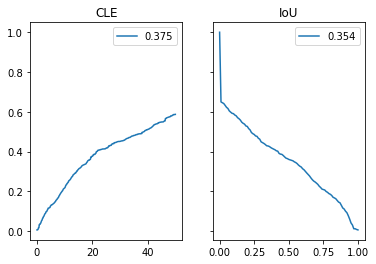

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x_cle, perf_cle, label='%.3f' % (sum(perf_cle) / len(perf_cle)))
ax1.set_title('CLE')
ax1.legend()
ax2.plot(x_iou, perf_iou, label='%.3f' % (sum(perf_iou) / len(perf_iou)))
ax2.set_title('IoU')
ax2.legend()

## Previews

In [20]:
from PIL import Image, ImageDraw
from IPython.display import display

In [21]:
def rectangle_width(image, x, y, w, h, outline, width=5):
    for step in range(width):
        image.rectangle(((x+step, y+step), (x+w+step, y+h+step)), outline=outline)

In [22]:
for seq, oo in rb.items():
    if not seq: continue
    ig = Image.open(path.join(data_path, 'img1', '%06d.jpg' % (seq)))
    dr = ImageDraw.Draw(ig)
    for o, value in seqs[seq].items():
        x, y, w, h, *_ = map(float, value)
#         dr.rectangle(((x, y), (x+w, y+h)), outline="red")
#         rectangle_width(dr, x, y, w, h, 'red')
    for o, value in oo.items():
        x, y, w, h, *_ = map(float, value)
#         dr.rectangle(((x, y), (x+w, y+h)), outline="blue")
#         rectangle_width(dr, x, y, w, h, 'blue')
#     display(ig)

## MOTA

In [36]:
import json

hypotheses = {}
groundtruth = {}
num = 0

In [37]:
hypotheses['frames'] = []
hypotheses['class'] = "video"
hypotheses['filename'] = "/home/maybe/MOT/labs/mot17.idx"
groundtruth['frames'] = []
groundtruth['class'] = "video"
groundtruth['filename'] = "/home/maybe/MOT/labs/mot17.idx"
print(json.dumps(groundtruth))

{"filename": "/home/maybe/MOT/labs/mot17.idx", "class": "video", "frames": []}


In [38]:
for seq, oo in rb.items():
    if not seq: continue
    # hypotheses
    hypotheses["frames"].append({"timestamp": num})
    hypotheses["frames"][num]["num"] = num
    hypotheses["frames"][num]["class"] = "frame"
    hypotheses["frames"][num]["hypotheses"] = []
    idx = 0
    for o, value in seqs[seq].items():
        x, y, w, h, *_ = map(float, value)
        hypotheses["frames"][num]["hypotheses"].append({"height": h, "width": w, "id": idx, "y": y, "x":x})
        idx += 1
    # groundtruth
    groundtruth["frames"].append({"timestamp": num})
    groundtruth["frames"][num]["num"] = num
    groundtruth["frames"][num]["class"] = "frame"
    groundtruth["frames"][num]["annotations"] = []
    idx = 0
    for o, value in oo.items():
        x, y, w, h, *_ = map(float, value)
        groundtruth["frames"][num]["annotations"].append({"dco": False, "height": h, "width": w, "id": idx, "y": y, "x":x})
        idx += 1
    num += 1

# with open('hypotheses.txt', 'w') as outfile:
#     json.dump(hypotheses, outfile)
    
# with open('groundtruth.txt', 'w') as outfile:
#     json.dump(groundtruth, outfile)
print(groundtruth["frames"][0])
print(hypotheses["frames"][0])

{'num': 0, 'class': 'frame', 'timestamp': 0, 'annotations': [{'y': 465.0232849121094, 'height': 97.31388092041016, 'width': 91.82291412353516, 'x': 920.6925659179688, 'dco': False, 'id': 0}, {'y': 418.0, 'height': 379.0, 'width': 167.0, 'x': 1338.0, 'dco': False, 'id': 1}, {'y': 447.0, 'height': 263.0, 'width': 85.0, 'x': 586.0, 'dco': False, 'id': 2}, {'y': 0.0, 'height': 566.344970703125, 'width': 329.2247619628906, 'x': 1589.7752685546875, 'dco': False, 'id': 3}, {'y': 439.8048400878906, 'height': 89.3607406616211, 'width': 33.133758544921875, 'x': 1157.5791015625, 'dco': False, 'id': 4}, {'y': 438.739013671875, 'height': 118.1908187866211, 'width': 34.05498504638672, 'x': 1311.1939697265625, 'dco': False, 'id': 5}, {'y': 431.0, 'height': 336.0, 'width': 184.0, 'x': 1416.0, 'dco': False, 'id': 6}, {'y': 484.0, 'height': 110.0, 'width': 36.0, 'x': 1056.0, 'dco': False, 'id': 7}, {'y': 484.0, 'height': 115.0, 'width': 31.0, 'x': 1091.0, 'dco': False, 'id': 8}, {'y': 487.0, 'height': 6

In [39]:
import sys
sys.path.append("/home/maybe/pymot")
from pymot import MOTEvaluation

In [45]:
evaluator = MOTEvaluation(groundtruth, hypotheses, 0.2)
evaluator.evaluate()
evaluator.getMOTA()

0.20532099479467902

In [46]:
evaluator.getMOTP()

0.5506946548082957

In [47]:
evaluator.getRelativeStatistics()

{'MOTA': 0.20532099479467902,
 'MOTP': 0.5506946548082957,
 'false positive rate': 0.3724696356275304,
 'mismatch rate': 0.05089647194910353,
 'miss rate': 0.3713128976286871,
 'non-recoverable mismatch rate': 0.042220936957779065,
 'recoverable mismatch rate': 0.04164256795835743,
 'track precision': 1.0,
 'track recall': 1.0}

In [48]:
evaluator.getAbsoluteStatistics()

{'correspondences': 1087,
 'covered ground truth tracks': 15,
 'covering hypothesis tracks': 15,
 'false positives': 644,
 'ground truth tracks': 15,
 'ground truths': 1729,
 'hypothesis tracks': 15,
 'lonely ground truth tracks': 0,
 'lonely hypothesis tracks': 0,
 'mismatches': 88,
 'misses': 642,
 'non-recoverable mismatches': 73,
 'recoverable mismatches': 72,
 'total overlap': 598.6050897766174}